# September 10,2020

## Plotting Data on a World Map

### Drawing a World Map

The first step I need to tackle in creating visualizations is to produce a blank world map in a projection that is well suited to the data. As I intend to primarily focus on Atlantic Hurricane data at least to begin with in this investigation, a projection that shows much of the Atlantic basin in a way that minimizes distortion and provides a helpful perspective when looking at the tracks of storms is ideal.

I'll start by experimenting with some different options in cartopy.

In [1]:
import os, sys
import cartopy
import matplotlib.pyplot as plt

root_dir = os.path.join(os.getcwd(), '..')
sys.path.append(root_dir)

import pandas as pd
import numpy as np

In [2]:
# We'll import the newly partitioned and cleaned datasets to work with.
positions = pd.read_csv('../data/02_intermediate/Atlantic_positions.csv')
storms = pd.read_csv('../data/02_intermediate/Atlantic_storms.csv')

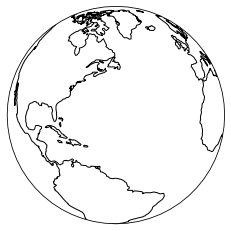

In [3]:
# Let's plot the blank map using the NearsidePerspective projection, and test some parameters.

projection = cartopy.crs.NearsidePerspective(central_longitude = -55, central_latitude = 30,  satellite_height = 10000000)
fig = plt.figure()
hurricane_map = fig.add_subplot(1, 1, 1,
                     projection = projection)

hurricane_map.set_global()
hurricane_map.coastlines()

This looks like it would work well! It's rare if ever that an Atlantic storm travels outside the area shown on this map, and the perspective is visually pleasing and minimizes distortion.

### Drawing a path as a scatter of points

It seems that, when plotting a path on the map, it would be easiest to start with a scatter to be able to view the result as the discrete observations form the data.

To create a list of positions for a storm, we'll go ahead and create a few simple functions that return the subset of points corresponding to a unique stormID as a list, one for latitude, `track_lat()`, and one for longitude, `track_lon()`.

Then we can use these functions to select two sample storms to plot for comparison, `lat1` and `lon1` corresponding to Hurricane Isabel (2003), `lat2` and `lon2` corresponding to Hurricane Katrina (2005), both significant storms, each of which had a lengthy track and ones which are distinct in appearance.

Finally, we can set our projection again, plot the blank map, and add the scatters of the tracks.


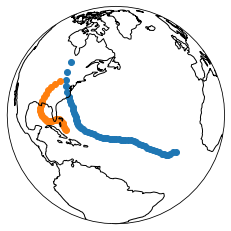

In [4]:
# create functions to query longitude and latitude data for a particular storm

def track_lat(stormID):
    return(positions['lat'][positions['stormID'] == stormID].tolist())

def track_lon(stormID):
    return(positions['lon'][positions['stormID'] == stormID].tolist())
    
lat1, lon1 = track_lat('AL132003'), track_lon('AL132003')
lat2, lon2 = track_lat('AL122005'), track_lon('AL122005')

projection = cartopy.crs.NearsidePerspective(central_longitude = -55, central_latitude = 30,  satellite_height = 10000000)
fig = plt.figure()
hurricane_map = fig.add_subplot(1, 1, 1,
                     projection = projection)

hurricane_map.set_global()
hurricane_map.coastlines()

# add entire tracks to the map
hurricane_map.scatter(lon1, lat1, transform = cartopy.crs.PlateCarree())
hurricane_map.scatter(lon2, lat2, transform = cartopy.crs.PlateCarree())

I feel like I understand the basics of getting a storm track to show up on the map now. 

The next step should be making the plot more legible... making it larger, adding a title, and using lines for paths instead of just the scatter. Both can be useful, as the scatter can give a better idea of velocity since the points are (generally) spaced apart equally in time. However, lines are more legible, particularly with a large number of storms, and with the ultimate goal of a heat map, neither will ultimately be relevant.

I also want to try automating the process of adding additional storms, so I'll use the previous two functions to build a new function that takes in a year and produces a chart that represents a yearly summary, with tracks for all the storms in that hurricane season.

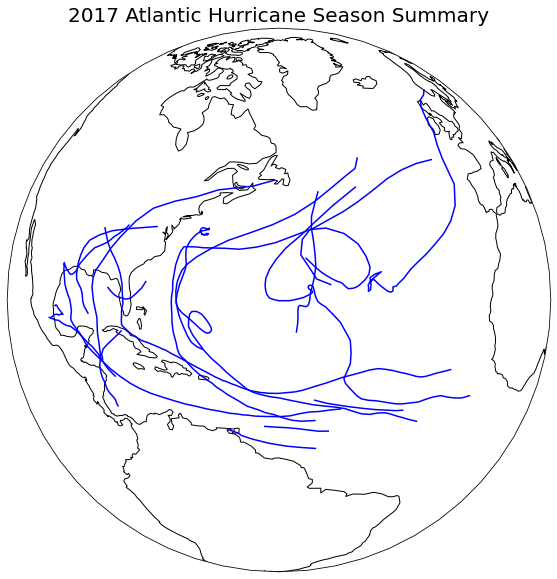

In [5]:
# Plot a yearly summary

# Take a year and optional flag to export image to file as arguments.
def plot_season_summary(year, export = False):
    # Increase image size to 10x10
    fig = plt.figure(figsize=(10,10))
    # Use earlier definition of projection.
    ax = plt.axes(projection = projection)
    ax.set_global()
    ax.coastlines()
    # Add title.
    plt.title(f"{year} Atlantic Hurricane Season Summary", fontsize = 20)

    # For every storm in the given year, repeat the steps used above (using ax.plot instead of scatter)
    for stormID in storms['stormID'][storms['year'] == year]:
        lat, lon = track_lat(stormID), track_lon(stormID)
        ax.plot(lon, lat, transform = cartopy.crs.PlateCarree(), c = "blue")
        
    # If export is chosen, export to image with standardized filename based on year.
    if export:
        fig.savefig(f"../results/images/{year}summary.jpg")
    
plot_season_summary(2017, export = True)

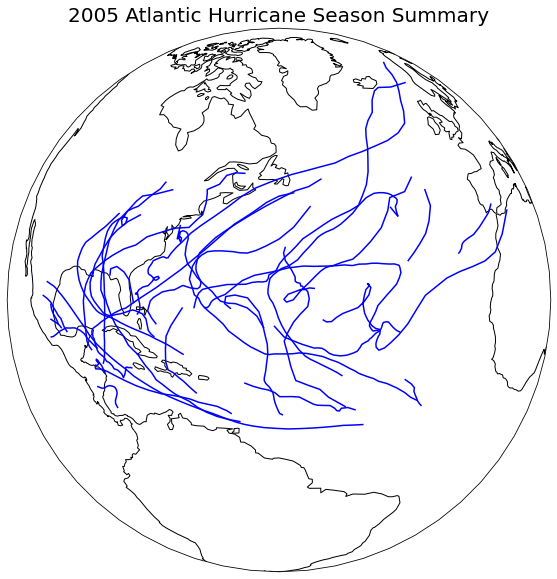

In [6]:
# Second example for a different season.
plot_season_summary(2005, export = True)

These results are basically what I was expecting! There are some options that could be tweaked but the most important takeaway for me is that we're able to iterate through storms based on the results of a query of the dataset and plot their tracks on the same map.

This can easily be extrapolated to a single storm, and I'd like to be able to combine it with a function to look up a stormID when provided a storm name and year, which is information one would much more likely to have readily. Also, for more detail looking at a single storm, whether to focus just on that track or show the global map we've used previously would also be a nice option.

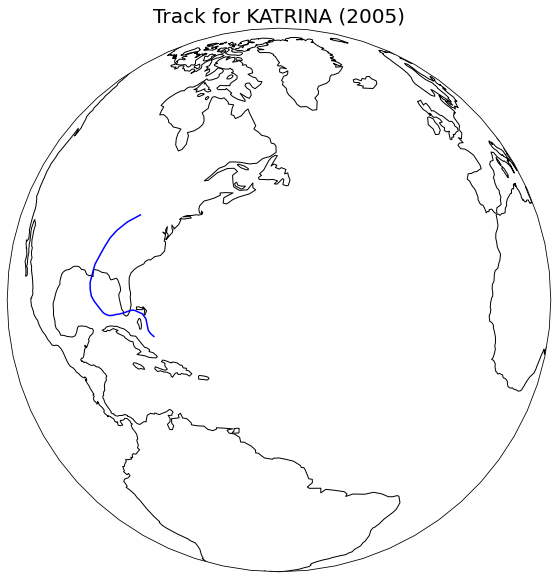

In [7]:
# plot an individual storm track
# how to look up name and year based on ID

# Take stormID, flags for export to file, global view vs. focus on storm track.
def plot_storm_track(stormID, global_view = False, export = False):
    # We're going to write a function to look up a stormID based on year and name.
    # In some cases, like years before modern recordkeeping where most storms are "UNNAMED",
    # multiple storms will be returned.
    # In other cases, if provided with a nonexistent combination, there will be no results.
    # In either case, that function will return None for the stormID, so we want this function
    # to exit gracefully if the stormID provided is None.
    if stormID == None:
        return
    
    # Otherwise, get information to use in the title and filenae.
    storm = storms[storms['stormID']== stormID]
    name = storm['name'].to_string(index = False).strip()
    year = storm['year'].to_string(index = False).strip()
    
    # Plot the track with title.
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection = projection)
    if global_view:
        ax.set_global()
    ax.coastlines()
    plt.title(f"Track for {name} ({year})", fontsize = 20)
    
    ax.plot(track_lon(stormID), track_lat(stormID), transform = cartopy.crs.PlateCarree(), c = "blue")
    
    # Export the file if requested.
    if export:
        fig.savefig(f"../results/images/{name}{year}track.jpg")

# Example run for Katrina (2005)
plot_storm_track('AL122005', global_view = True)

Now, to create the function to look up stormID. We can nest this inside the previous `plot_storm_track()` function so that, in the event that a unique name and year combination is entered and a single stormID is returned, the track can be immediately plotted. We do need to account for the other cases, however, returning `None` when the combination doesn't produce a unique stormID.

In [8]:
# create function to return storm ID
def stormID(name, year):
    # Convert name to all upper case.
    name = name.upper()
    # Create a subset containing all the results that match the query.
    match = storms[(storms['name'] == name) & (storms['year'] == year)]
    
    # Return None and print an appropriate message.
    # By structuring the function this way, we notify the user of the result while doing nothing, and
    # passing an appropriate None value if it's nested inside the other function.
    # Length of match is 0 when no result.
    if len(match.index) == 0:
        print("Storm not found.")
        return None
    # Length of match is 0 where multiple storms match (e.g. "UNNAMED" multiple times in a year)
    if len(match.index) > 1:
        print("Found multiple results.")
        print(match['stormID'])
        return None
    
    stormID = match['stormID'].to_string(index = False).strip()
    return stormID

Now we can test using the function on its own and nested.

In [9]:
# Standalone, single value expected.
stormID("Matthew", 2016)

'AL142016'

In [10]:
# Standalone, no value expected.
stormID("NotAStormName", 2012)

Storm not found.


In [11]:
# Standalone, multiple values expected.
stormID("Unnamed", 1890)

Found multiple results.
289    AL011890
290    AL021890
291    AL031890
292    AL041890
Name: stormID, dtype: object


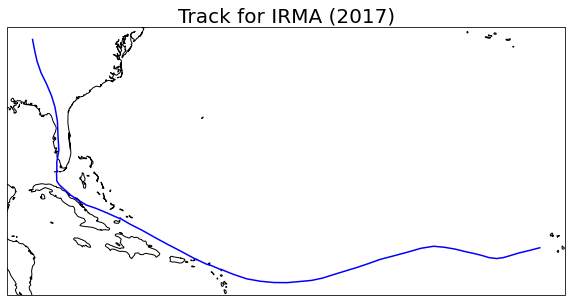

In [12]:
# Nested functions; single value expected. Test out non-global view, too.
plot_storm_track(stormID("Irma", 2017), global_view = False, export = True)

In [13]:
# Nested, when stormID is none:
plot_storm_track(stormID("NotAStormName", 2012), global_view = True, export = True)

Storm not found.


These functions are definitely useful for plotting tracks! It would be easy enough to incorporate either in a loop to produce multiple season summaries or plots for multiple storms, though neither has yet been designed to take an arbitrary list of stormIDs and plot them all on the same map. This can be a task for another time. 

## Modularizing

These functions would be ideal to call in other parts of the analysis, so we'll move them into a module `storm_tracks.py` in `/src/d07_visualization`.

All the prerequisite functions, `track_lat()`, `track_lon()`, and `stormID()` will be included, as well as `plot_storm_track()` and `plot_season_summary()`. All the functions will need to accept an additional parameter for the dataframes for `Storms` and `Positions` they're meant to read from, though in the module we can set defaults to the expected locations for these files.

I'll then test the functions below.

In [14]:
import os, sys
import pandas as pd

root_dir = os.path.join(os.getcwd(), '..')
sys.path.append(root_dir)

from src.d07_visualization import storm_tracks as trk

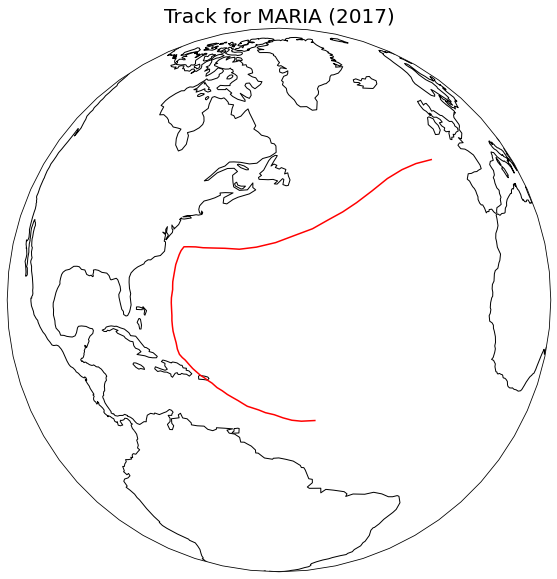

In [15]:
# We won't specify dataframes to make sure it uses the defaults.
trk.plot_storm_track(stormID("Maria", 2017), global_view = True, export = False)

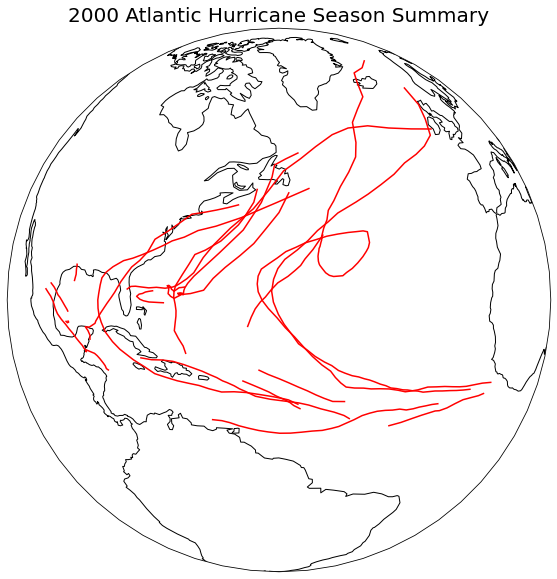

In [16]:
trk.plot_season_summary(2000, export = False)

Exerything seems to be working as expected!

Now that we have some practical and useufl visualizations in place, we can experiment with some more complex visualizations, like heat maps (as one of my end goals is to explore frequency based on geographic location).